In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import math

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
from pandas_datareader import data as pdr
import yfinance as yf

import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff
from afml.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from afml.sample_weights.attribution import get_weights_by_return, get_weights_by_time_decay
from afml.feature_importance.importance import mean_decrease_impurity, mean_decrease_accuracy, single_feature_importance, plot_feature_importance
from afml.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.utils import resample
from sklearn.utils import shuffle

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Import Dataset

In [6]:
# df_yf = gd.get_yf_data(tickers= "SPY COMP ALGM", 
#                     period='60d',   
#                     interval='5m'
# )

# df = df_yf[df_yf['Ticker'] == 'ALGM']
# index_SPY = df_yf[df_yf['Ticker'] == 'SPY']
# index_COMP = df_yf[df_yf['Ticker'] == 'COMP']

In [7]:
# download dataframe

yf.pdr_override()

def get_yf_daily(ticker, startdate, enddate, years):
    df = pd.DataFrame()
    for i in range(years):
        start = startdate.replace(startdate.year-i).strftime('%Y-%m-%d')
        end = enddate.replace(enddate.year-i).strftime('%Y-%m-%d')
        thisdf = pdr.get_data_yahoo(ticker, start=start, end=end)
        df= pd.concat([df, thisdf], axis= 0)
        print('Complete {} {}'.format(ticker, enddate.year-i))
    return df

years = 10
startdate= datetime.date(2021, 1, 1)
enddate = datetime.date(2021, 12, 31)

df = get_yf_daily('HAL', startdate, enddate, years).sort_index(ascending=True)
index_SPY = get_yf_daily('SPY', startdate, enddate, years).sort_index(ascending=True)
#index_COMP = get_yf_daily('COMP', startdate, enddate, years)


[*********************100%***********************]  1 of 1 completed
Complete HAL 2021
[*********************100%***********************]  1 of 1 completed
Complete HAL 2020
[*********************100%***********************]  1 of 1 completed
Complete HAL 2019
[*********************100%***********************]  1 of 1 completed
Complete HAL 2018
[*********************100%***********************]  1 of 1 completed
Complete HAL 2017
[*********************100%***********************]  1 of 1 completed
Complete HAL 2016
[*********************100%***********************]  1 of 1 completed
Complete HAL 2015
[*********************100%***********************]  1 of 1 completed
Complete HAL 2014
[*********************100%***********************]  1 of 1 completed
Complete HAL 2013
[*********************100%***********************]  1 of 1 completed
Complete HAL 2012
[*********************100%***********************]  1 of 1 completed
Complete SPY 2021
[*********************100%*****************

## Get Labels: Trend Scanning method

In [8]:
# convert Adj Close to numpy
time_series = df['Adj Close'].to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='up')

# drop last rolling window size -1 rows
n = window_size_max-1
#df.drop(df.tail(n).index, inplace = True)
df = df.iloc[:-n]

# append the slope and labels to the df
df['slope'] = label_output['slope']
df['label'] = label_output['label']
# df['isEvent'] = label_output['isEvent']
# isEvent = df[df['isEvent']==1].index

## Get Labels: Simple moving average cross over strategy

In [9]:
# need to cite here ...

# compute moving averages
fast_window = 20
slow_window = 50

df['fast_mavg'] = df['Adj Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = df['Adj Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df.head()

# Compute sides
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

## Raw Data 

In [10]:
# Save the raw data
raw_data = df.drop(columns='Close').copy()

# Drop the NaN values from our data set
df.dropna(axis=0, how='any', inplace=True)

In [11]:
print(df['label'].value_counts())
print(df['side'].value_counts())

 1    1283
-1    1170
Name: label, dtype: int64
 1.0    1251
-1.0    1202
Name: side, dtype: int64


## Form Dollar Bars

In [12]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20
#frequency = df['Volume'].resample('D').sum().mean()/10.0

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = dollar_bars.close.copy()

## Filter Events using CUSUM Filter

We will then predict what will happen if the event is triggered, based on the 'side' signal from the Trend Following Strategy 

In [13]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed threshold
#tEvents = flt.getTEvents(close, h=dailyVolatility.mean()*0.5)
tEvents = flt.cusum_filter(close, threshold=dailyVolatility.mean()*0.5, signal=None)

# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [14]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(df.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

## Create Trade or Not Trade labels using Triple Barrier Method

In [15]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents, 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()

labels = tbar.get_bins(triple_barrier_events = events, close=close)

# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)
print(clean_labels.bin.value_counts())

0    673
1    383
Name: bin, dtype: int64


In [16]:
clean_labels

,ret,trgt,bin,side
2012-03-21,0.050800,0.020483,1,-1.0
2012-03-22,-0.014051,0.029961,0,-1.0
2012-03-26,0.026854,0.024900,0,-1.0
2012-03-27,-0.022916,0.022602,0,-1.0
2012-03-30,0.025016,0.023329,0,-1.0
...,...,...,...,...
2021-11-23,0.017272,0.038763,0,-1.0
2021-11-26,-0.041187,0.039638,0,-1.0
2021-12-02,0.082463,0.038329,1,1.0
2021-12-06,0.001039,0.037933,0,1.0


## Results of Secondary Model without features

In [17]:
primary_forecast = pd.DataFrame(clean_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       673
           1       0.36      1.00      0.53       383

    accuracy                           0.36      1056
   macro avg       0.18      0.50      0.27      1056
weighted avg       0.13      0.36      0.19      1056

Confusion Matrix
[[  0 673]
 [  0 383]]

Accuracy
0.3626893939393939


#### Fitting a Meta model

Use features: volatility, serial correlation, relative strength to S&P and COMP

In [18]:
# Save the raw data
raw_data = df.drop(columns='Close').copy()

raw_data.head()

,Open,High,Low,Adj Close,Volume,slope,label,fast_mavg,slow_mavg,side
Date,,,,,,,,,,
2012-03-15,34.349998,34.410000,33.700001,28.358381,18789900,-0.146231,-1,30.050605,30.005003,1.0
2012-03-16,34.110001,34.779999,33.830002,28.885233,18628800,0.091989,1,30.008330,29.996768,1.0
2012-03-19,34.680000,35.299999,34.400002,29.269920,13140300,-0.559472,-1,29.958178,30.005571,1.0
2012-03-20,34.630001,34.840000,34.259998,29.069210,14828500,-0.432357,-1,29.867124,30.003351,-1.0
2012-03-21,34.090000,34.450001,33.849998,28.542355,20965700,-0.296881,-1,29.699260,29.983921,-1.0


#### Features

In [19]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['Adj Close']).diff()

# Momentum
raw_data['mom1'] = raw_data['Adj Close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['Adj Close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['Adj Close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['Adj Close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['Adj Close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=3, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=3, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=3, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=3, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\choit\OneDrive\Coursera\SIADS699\env1\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


In [20]:
# # Re compute sides
# raw_data['side'] = np.nan

# long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
# short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

# raw_data.loc[long_signals, 'side'] = 1
# raw_data.loc[short_signals, 'side'] = -1

In [21]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

In [22]:
raw_data.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'slope', 'label',
       'fast_mavg', 'slow_mavg', 'side', 'log_ret', 'mom1', 'mom2', 'mom3',
       'mom4', 'mom5', 'volatility_50', 'volatility_31', 'volatility_15',
       'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
       'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5'],
      dtype='object')

In [23]:
# serial correlation
srl_corr = mkt.df_rolling_autocorr(mkt.returns(close), window=7).rename('srl_corr')

# relative strength to SPY
rs_SPY = mkt.get_relative_strength(df['Adj Close'], index_SPY['Adj Close']).shift(1).dropna()

# relative strength to COMP
#rs_COMP = mkt.get_relative_strength(df['Adj Close'], index_COMP['Adj Close']).shift(1).dropna()


In [24]:
# fractional differentiated log dollar bar prices

# cumulative sum of stock log-prices
ticker_log_cumsum = np.log(dollar_bars.close).cumsum()

# frac diff 1 time
dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()

# apply cumsum filter
dfx1_close = dfx1.close.copy()
df_tEvents = flt.getTEvents(dfx1_close, h=dfx1.std().iat[0]*2)

# fracDiff value feature
frac_diff_feat = dfx1.loc[df_tEvents] 


In [25]:
features = (pd.DataFrame()
            .assign(vol=events.trgt)
            #.assign(side=clean_labels.side)
            #.assign(srl_corr=srl_corr)
            .assign(rs_SPY=rs_SPY)
            #.assign(rs_COMP=rs_COMP)
            #.assign(frac_diff_feat=frac_diff_feat)
            .drop_duplicates()
            .dropna())

In [26]:
# Get features at event dates
_X = raw_data.loc[clean_labels.index, :]

In [27]:
# Drop unwanted columns
_X.drop([#'Ticker',
        'Adj Close', 'High', 'Low', 'Open', 'Volume', 
        #'fast_mavg', 'slow_mavg', 'side', # remove for MA crossover
        #'slope', 'label', # remove for trend scanning
        ], axis=1, inplace=True)

In [28]:
Xy = _X.join(features).join(clean_labels['bin']).dropna()

In [29]:
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]

In [30]:
y.value_counts()

0    671
1    382
Name: bin, dtype: int64

In [31]:
Xy.columns

Index(['slope', 'label', 'fast_mavg', 'slow_mavg', 'side', 'log_ret', 'mom1',
       'mom2', 'mom3', 'mom4', 'mom5', 'volatility_50', 'volatility_31',
       'volatility_15', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4',
       'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'vol',
       'rs_SPY', 'bin'],
      dtype='object')

In [58]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=RANDOM_STATE)

## Sample Weights

In [59]:
# training data sample weights

return_based_sample_weights = get_weights_by_return(events.loc[X_train.index], df.loc[X_train.index, 'Adj Close'])
time_based_sample_weights = get_weights_by_time_decay(events.loc[X_train.index], df.loc[X_train.index, 'Adj Close'], decay=0.5)

# test data sample weights

return_based_sample_weights_test = get_weights_by_return(events.loc[X_test.index], df.loc[X_test.index, 'Adj Close'])
time_based_sample_weights_test = get_weights_by_time_decay(events.loc[X_test.index], df.loc[X_test.index, 'Adj Close'], decay=0.5)

2023-03-22 22:47:19.107313 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:20.402505 100.0% _apply_weight_by_return done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:21.586848 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:22.731778 100.0% _get_average_uniqueness done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:23.848471 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:24.996311 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:26.138807 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-22 22:47:27.295206 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


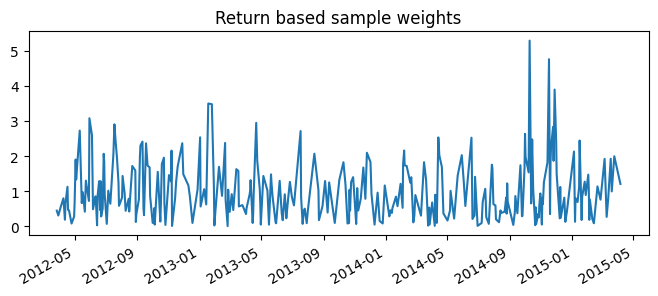

In [34]:
plt.figure(figsize=(8,3))
plt.title('Return based sample weights')
return_based_sample_weights.plot()
plt.show()

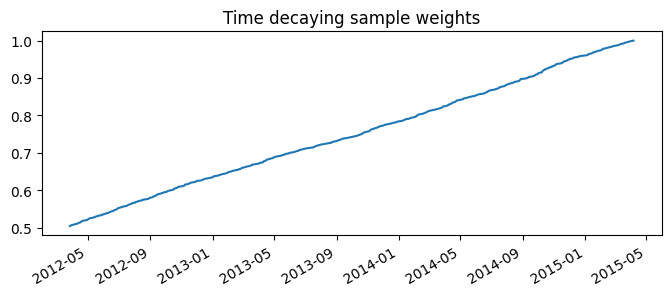

In [35]:
plt.figure(figsize=(8,3))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

## Cross-Validation 

In [36]:
def get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring, sample_weight, scaler=StandardScaler()):
    t0 = 0.0
    t1 = 0.0

    best_param_dict = {}
    best_param_dict['type'] = type
    best_param_dict['top_model'] = None
    best_param_dict['max_cross_val_score'] = -np.inf
    best_param_dict['max_cross_val_score_recall'] = -np.inf
    best_param_dict['max_cross_val_score_precision'] = -np.inf
    best_param_dict['max_cross_val_score_accuracy'] = -np.inf
    best_param_dict['run_time'] = 0.0

    col = X_train.columns.to_list()
    idx = X_train.index

    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col, index=idx)

    t0 = time.time()
    temp_score_base, temp_recall, temp_precision, temp_accuracy = ml_cross_val_score(clf, X_train_scaled, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)
    t1 = time.time()
    
    if temp_score_base.mean() > best_param_dict['max_cross_val_score']:
        best_param_dict['top_model'] = clf
        best_param_dict['max_cross_val_score'] = temp_score_base.mean()
        best_param_dict['max_cross_val_score_recall'] = temp_recall.mean()
        best_param_dict['max_cross_val_score_precision'] = temp_precision.mean()
        best_param_dict['max_cross_val_score_accuracy'] = temp_accuracy.mean()
        best_param_dict['run_time'] = t1-t0    
    
    return best_param_dict

def perform_grid_search(X_train, y_train, cv_gen, scoring, parameters, type='standard', sample_weight=None, RANDOM_STATE=42):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """

    if type=='SVC' or type=='seq_boot_SVC':
        for C in parameters['C']:
            for gamma in parameters['gamma']:

                clf_SVC = SVC(C=C,
                                gamma=gamma,
                                class_weight='balanced',
                                kernel='linear',
                                random_state=RANDOM_STATE)

                if type =='SVC':
                    clf = clf_SVC
                elif type == 'seq_boot_SVC':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                estimator=clf_SVC, 
                                                                random_state=RANDOM_STATE, n_jobs=-1, oob_score=False,
                                                                max_features=1.)

                # get best param dict   
                best_param_dict = get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)


    else:    
        for m_depth in parameters['max_depth']:
            for n_est in parameters['n_estimators']:
                clf_base = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, 
                                                max_depth=m_depth, class_weight='balanced')

                if type == 'standard_bagging':
                    clf = BaggingClassifier(n_estimators=n_est, 
                                            estimator=clf_base, 
                                            random_state=RANDOM_STATE, n_jobs=-1, 
                                            oob_score=False, max_features=1.)
                elif type == 'random_forest':
                    clf = RandomForestClassifier(n_estimators=n_est, 
                                                max_depth=m_depth, 
                                                random_state=RANDOM_STATE, 
                                                n_jobs=-1, 
                                                oob_score=False, 
                                                criterion='entropy',
                                                class_weight='balanced_subsample', 
                                                max_features=1.)
                elif type == 'sequential_bootstrapping':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                    price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                    estimator=clf_base, 
                                                                    n_estimators=n_est, 
                                                                    random_state=RANDOM_STATE, 
                                                                    n_jobs=-1, 
                                                                    oob_score=False,
                                                                    max_features=1.)
                
                # get best param dict   
                best_param_dict = get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)

    return best_param_dict

In [37]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 25, 50, 100, 256, 512],
              'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              }

In [38]:
n_splits=4

cv_gen_standard = KFold(n_splits)
cv_gen_purged = PurgedKFold(n_splits=n_splits, samples_info_sets=events.loc[X_train.index].t1)

In [39]:
warnings.filterwarnings('ignore')

In [40]:

selected_models = ['standard_bagging', 
                   'random_forest', 
                   'sequential_bootstrapping', 
                   'SVC', 
                   'seq_boot_SVC'
                   ]

model_metrics = pd.DataFrame(columns = ['type', 'top_model', 'max_cross_val_score', 'max_cross_val_score_recall', 'max_cross_val_score_precision', 'max_cross_val_score_accuracy','run_time'])


for clf in selected_models:
    best_params = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, type=clf, sample_weight=return_based_sample_weights.values)
    model_metrics = model_metrics.append(best_params, ignore_index = True)  
    print('Completed {}'.format(clf))


Completed standard_bagging
Completed random_forest
Completed sequential_bootstrapping
Completed SVC
Completed seq_boot_SVC


In [41]:
model_metrics

,type,top_model,max_cross_val_score,max_cross_val_score_recall,max_cross_val_score_precision,max_cross_val_score_accuracy,run_time
0,standard_bagging,(DecisionTreeClassifier(class_weight='balanced...,0.219772,0.208724,0.613486,0.435224,2.185365
1,random_forest,"(DecisionTreeClassifier(criterion='entropy', m...",0.258194,0.234798,0.631142,0.451422,4.010296
2,sequential_bootstrapping,(DecisionTreeClassifier(class_weight='balanced...,0.214266,0.192471,0.588581,0.435676,23.427908
3,SVC,"SVC(C=1000, class_weight='balanced', gamma=0.0...",0.486936,0.530816,0.513652,0.494791,27.747375
4,seq_boot_SVC,"(SVC(C=1000, class_weight='balanced', gamma=0....",0.396740,0.401836,0.547040,0.467799,37.943511


In [42]:
top_model = model_metrics.sort_values(['max_cross_val_score']).tail(1)['top_model'].squeeze()
top_model

SVC(C=1000, class_weight='balanced', gamma=0.0001, kernel='linear',
    random_state=42)

In [43]:
best_SVC = model_metrics[model_metrics['type'] == 'seq_boot_SVC']['top_model'].squeeze()
best_SVC

SequentiallyBootstrappedBaggingClassifier(estimator=SVC(C=1000,
                                                        class_weight='balanced',
                                                        gamma=0.0001,
                                                        kernel='linear',
                                                        random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2012-03-27    27.455198
2012-03-28    27.162493
2012-03-29    27.405012
2012-03-30    27.756260
2012-04-02    27.973690
                ...    
2015-03-30    37.984562
2015-03-31    38.036594
2015-04-01    37.984562
2015-04-02    38.105923
2015-04-06    39.770245
Name: close, Length: 717, dtype: float64,
                                          random_state=42,
                                          samples_info_sets=2012-03-27   2012-04-03
2012-03-30   2012-04-09
2012-04-04   2012-04-16
2012-04-09   2012-04-18
2012-04-12   2012-04-13
                ...    
2015-03-18   2015-03-30
2015-03-20   2015-03-30
2015-03-25   2015-04-06
2015-03-31   2015-04-06
2015-04-06   2015-04-07
Name: t1, Length: 315, dtype: datetime64[ns])

## Feature Importance

The SVC classifier does not provide a direct wat to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

In [44]:
# Get coefficients of hyperplane
coef = best_SVC.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()


AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute 'coef_'

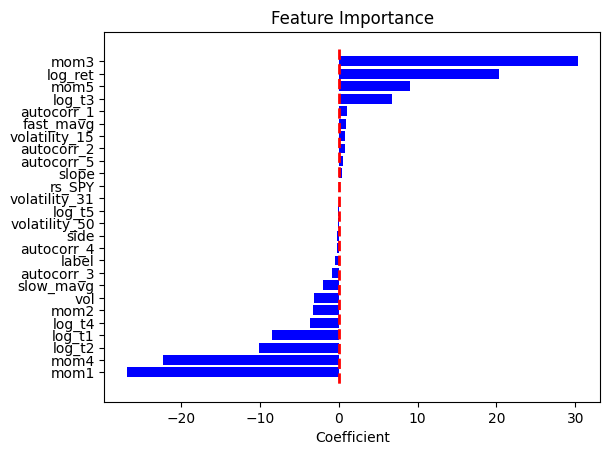

In [45]:
# Get coefficients of hyperplane
coef = top_model.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()

This codes below are for tress based Feature Importance

In [ ]:
# # MDI, MDA, SFI feature importance
# mdi_feat_imp = mean_decrease_impurity(top_model, X_train.columns)
# mda_feat_imp = mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring='f1', sample_weight=sw_train)
# sfi_feat_imp = single_feature_importance(top_model, X_train, y_train, cv_gen_purged, scoring='f1', sample_weight=sw_train)

In [ ]:
# plot_feature_importance(mdi_feat_imp, 0, 0)

In [ ]:
# plot_feature_importance(mda_feat_imp, 0, 0)

In [ ]:
# plot_feature_importance(sfi_feat_imp, 0, 0)

## Top Model Metrics

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       479
           1       0.00      0.00      0.00       259

    accuracy                           0.65       738
   macro avg       0.32      0.50      0.39       738
weighted avg       0.42      0.65      0.51       738



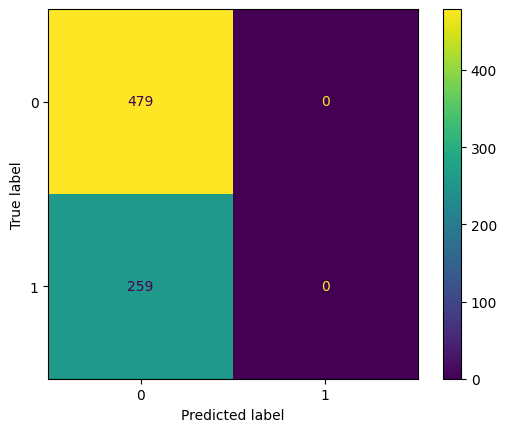

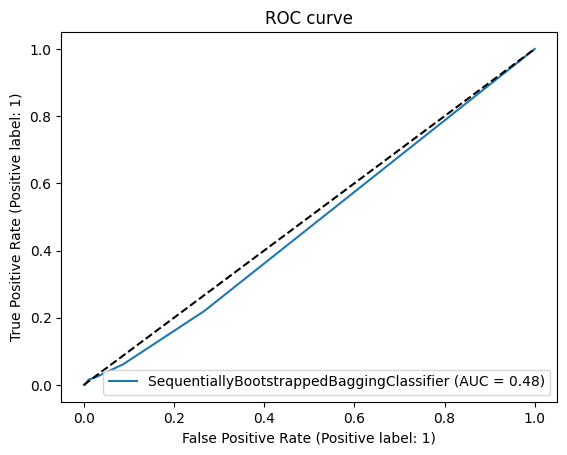

In [50]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score

#best_SVC_fitted = best_SVC.fit(X_train, y_train, sample_weight=return_based_sample_weights.values)
#y_pred = best_SVC_fitted.predict(X_test)
y_pred = best_SVC.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_SVC, X_test, y_test)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_SVC, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       479
           1       0.00      0.00      0.00       259

    accuracy                           0.65       738
   macro avg       0.32      0.50      0.39       738
weighted avg       0.42      0.65      0.51       738

0.0


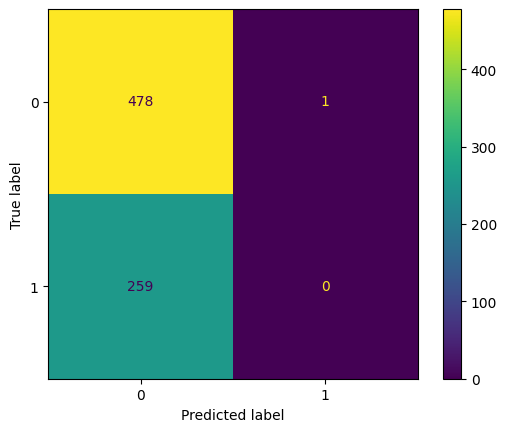

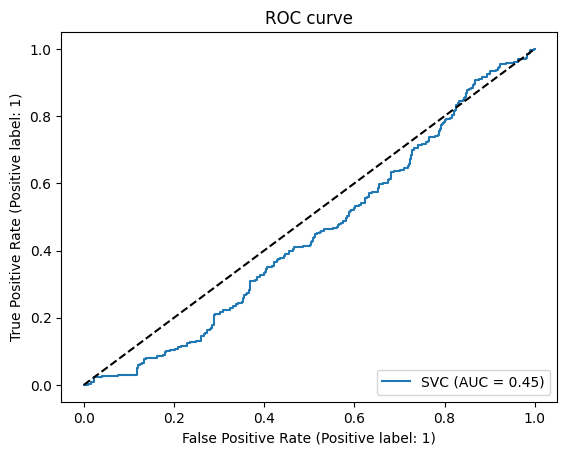

In [49]:
y_pred = top_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(top_model, X_test, y_test)
plt.show()

RocCurveDisplay.from_estimator(top_model, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

## Backtest

In [ ]:
clean_labels

,ret,trgt,bin,side
2017-03-27,0.030138,0.010763,1,1.0
2017-03-29,-0.015009,0.020202,0,-1.0
2017-04-06,0.036585,0.017609,1,-1.0
2017-04-13,0.034866,0.017106,1,-1.0
2017-04-19,0.047020,0.016549,1,-1.0
...,...,...,...,...
2021-11-23,0.017272,0.038293,0,-1.0
2021-11-26,-0.041187,0.039224,0,-1.0
2021-12-02,0.082463,0.037924,1,1.0
2021-12-06,0.001039,0.037529,0,1.0


In [ ]:
test_result_df = X_test[['slope', 'label']]
test_result_df['y_test'] = y_test
test_result_df['y_pred'] = y_pred

In [ ]:
test_result_df[test_result_df['label']==1].groupby('y_test').sum()


,slope,label,y_pred
y_test,,,
0,33.086664,108.0,3
1,17.143747,41.0,3


In [ ]:
import pandas as pd
   
   # Load the data
data = pd.read_csv('your_data.csv')
   
   # Calculate the daily returns
data['daily_returns'] = data['log_returns'].apply(lambda x: math.exp(x) - 1)

FileNotFoundError: [Errno 2] No such file or directory: 'your_data.csv'

In [ ]:
# Define transaction cost and slippage parameters
transaction_cost = 0.01  # 1% transaction cost
slippage = 0.005  # 0.5% slippage

# Calculate the trade returns
data['trade_returns'] = data['daily_returns'] * data['trade'].shift(1) - abs(data['trade'].diff()) * (transaction_cost + slippage)

In [ ]:
# Calculate the cumulative returns
data['cumulative_returns'] = (data['trade_returns'] + 1).cumprod() - 1

In [ ]:
# Line chart of the cumulative returns over time.

In [ ]:
import matplotlib.pyplot as plt
   
   # Visualize the results
plt.plot(data['date'], data['cumulative_returns'])
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.show()